In [ ]:
# all us stocks

In [ ]:
import pandas as pd
df = pd.read_csv("constituents.csv")
symbols = list(df['Symbol'])

In [11]:
import yfinance as yf
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2020-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

df = yf.download(symbols, start=train_start, end=datetime.now(), progress=False)
close = df['Adj Close']
close.dropna(how='any', axis=1, inplace=True)

pct_change = close.pct_change().dropna()
pct_change = pct_change.resample(resample_map['weekly']).sum()

In [17]:
pct_change = pct_change[pct_change.index >= "2023-01-01"]
modeling_end = datetime.now()

starter_index = np.where(pct_change.index < pd.to_datetime(modeling_end))[0][-1]
starter_index

73

In [21]:
len(pct_change), starter_index

(75, 73)

In [22]:
modeling_end = train_end_str

factors = []

indices = []
for index in range(len(pct_change)-starter_index+1):

    # rolling calculating time series
    pct_change_train = pct_change.iloc[index:starter_index+index]
    print(pct_change_train.index[0], pct_change_train.index[-1])
    prediction_factor = []
    for ticker in list(pct_change_train.columns):
        # get max lags with pacf
        pacf_values = pacf(pct_change_train[ticker], method='ywm')
        
        N = len(pct_change_train[ticker])
        threshold = 1.96 / np.sqrt(N)

        significant_indices = np.where(np.abs(pacf_values) > threshold)[0]
        significant_pacf_values = pacf_values[significant_indices]
        if len(significant_indices) >= 2:
            best_lag_n = significant_indices[1]
        elif len(significant_indices) == 1:
            best_lag_n = np.argmax(np.abs(pacf_values[1:])) + 1

        # get predictions(upward/downward)
        train_data = pct_change_train[ticker]
        model = sm.tsa.arima.ARIMA(train_data, order=(best_lag_n, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
        model_fit = model.fit()
        prediction = model_fit.forecast()
        # print(ticker, prediction[0], prediction.index[0])
        prediction_factor.append(prediction[0])
    factors.append(prediction_factor)
    indices.append(pct_change_train.index[-1])

2023-01-01 00:00:00 2024-05-19 00:00:00
2023-01-08 00:00:00 2024-05-26 00:00:00
2023-01-15 00:00:00 2024-06-02 00:00:00


<Axes: >

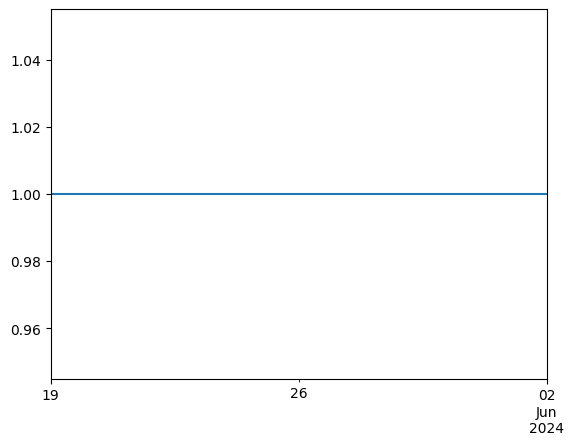

In [23]:
tester = pd.DataFrame(factors, columns=list(pct_change_train.columns), index=indices)
df1 = tester.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)
def normalize_weights(df):
    long_weights = df[df > 0]
    
    normalized_long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0)
    
    return normalized_long_weights

normalized_long_weights = normalize_weights(weighting)
# check weighting allocation for each time period
normalized_long_weights.sum(axis=1).plot()

In [24]:
close_prices_df = pd.DataFrame(df['Adj Close'])
close_prices_df.dropna(how='any', axis=1, inplace=True)
close_prices_df_m = close_prices_df.resample('M').mean()
close_prices_df_m.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,67.838050,32.775264,36.895410,67.096035,63.771561,27.691905,136.329358,237.954285,81.411837,37.163110,...,144.462995,19.582043,107.003779,42.828882,54.499248,64.483572,82.952845,97.610671,166.102857,81.481084
2019-02-28,74.562653,35.457866,41.228277,62.806602,68.371323,31.332631,146.540520,257.864214,94.118972,36.620801,...,157.121751,20.707459,121.166222,46.068624,58.904502,68.561086,85.458028,113.804922,190.626842,87.536961
2019-03-31,77.108169,31.333244,44.054432,62.660217,71.973837,32.383809,153.428747,261.037619,97.758762,36.952543,...,161.374890,20.722803,113.499562,48.361070,61.861988,72.665886,89.278431,116.708298,208.198571,93.373580
2019-04-30,76.312499,33.368811,48.193811,64.006646,71.242729,32.686190,166.371147,273.730001,102.672561,37.134217,...,167.172267,21.702519,135.408373,47.969709,62.777648,76.915625,92.475296,117.187550,225.187618,97.642041
2019-05-31,69.639065,31.339162,46.088560,62.798844,70.420613,34.043182,165.207830,277.341820,95.953917,35.692887,...,164.830833,19.980170,120.573498,49.605991,58.533354,72.378305,92.199346,110.547740,186.238636,98.621271


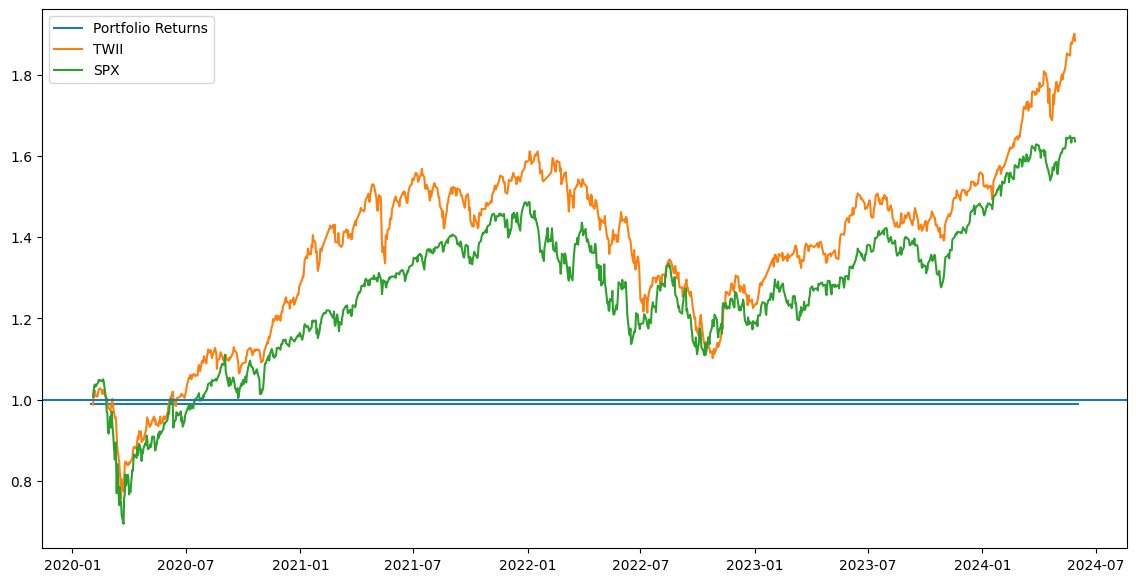

Sharpe Ratio: inf
CAGR: -0.25%
Karma Ratio: nan


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fee = 0.01
portfolio_returns = (normalized_long_weights * close_prices_df_m.pct_change()).sum(axis=1)
portfolio_returns = portfolio_returns[portfolio_returns.index >= modeling_end]
# Plot returns
plt.figure(figsize=(14, 7))
returns_series = (1 + portfolio_returns).cumprod()*(1-fee)
spx = yf.download("^GSPC", start=returns_series.index[0], end=returns_series.index[-1], progress=False)['Adj Close']
twii = yf.download("^TWII", start=returns_series.index[0], end=returns_series.index[-1], progress=False)['Adj Close']

plt.plot(returns_series, label='Portfolio Returns')

benchmark = pct_change[pct_change.index >= portfolio_returns.index[0]]

plt.plot((1 + twii.pct_change()).cumprod(), label='TWII')
plt.plot((1 + spx.pct_change()).cumprod(), label='SPX')
plt.axhline(1)
plt.legend()
plt.show()

# Calculate performance metrics
def sharpe_ratio(returns, risk_free_rate=0.03):
    excess_return = ((1 + returns).cumprod()*(1-fee)) - risk_free_rate
    return  (np.mean(excess_return)/ np.std(excess_return))**(1/4)
def karma_ratio(returns):
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]

    if len(negative_returns) == 0:
        karma_ratio = np.mean(positive_returns) / 0.00001  # Avoid division by zero
    else:
        karma_ratio = np.mean(positive_returns) / np.abs(np.mean(negative_returns))

    return karma_ratio

print("Sharpe Ratio:", sharpe_ratio(portfolio_returns))
print(f"CAGR: {np.round(((returns_series[-1])**(1/4)-1)*100, 2)}%")
print("Karma Ratio:", karma_ratio(portfolio_returns))



Maximum Drawdown (MDD): 0.00%


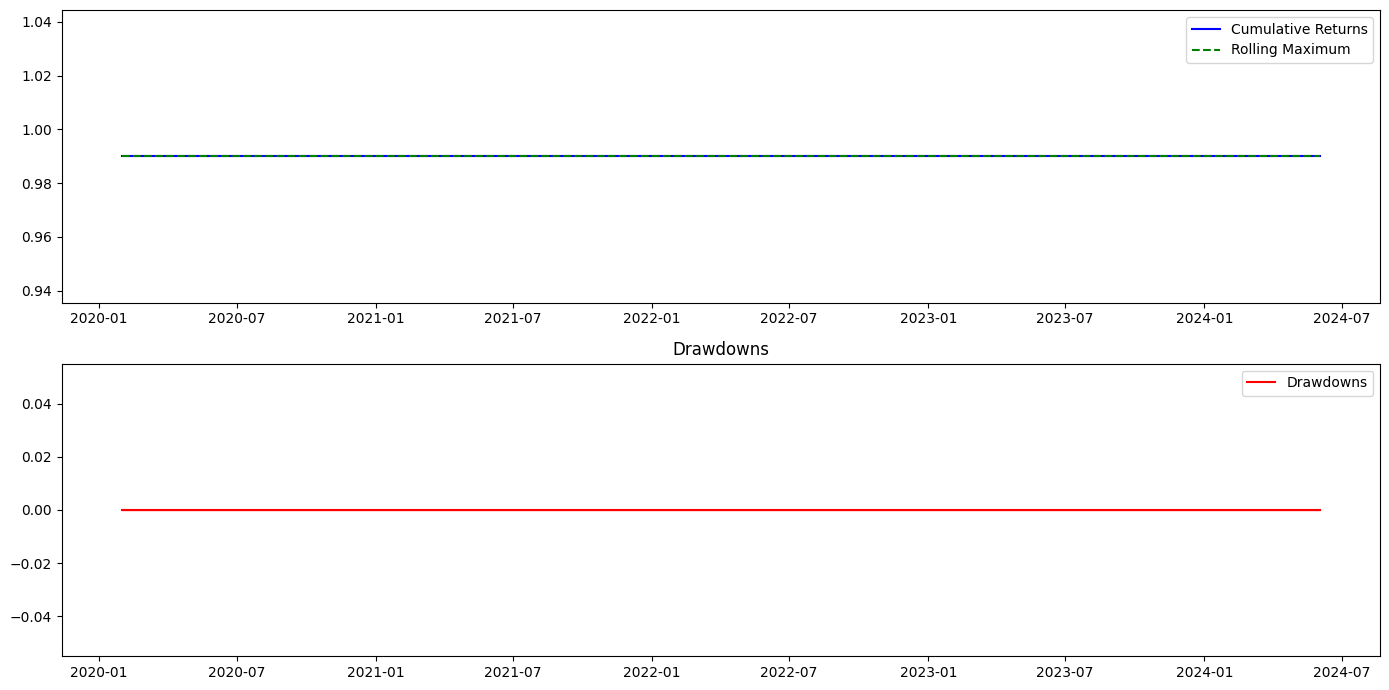

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


cumulative_returns = returns_series

rolling_max = cumulative_returns.cummax()

drawdowns = (cumulative_returns - rolling_max) / rolling_max

max_drawdown = drawdowns.min()

# Print the Maximum Drawdown
print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.plot(rolling_max, label='Rolling Maximum', color='green', linestyle='--')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdowns, label='Drawdowns', color='red')
plt.fill_between(drawdowns.index, drawdowns, color='red', alpha=0.3)
plt.title('Drawdowns')
plt.legend()

plt.tight_layout()
plt.show()


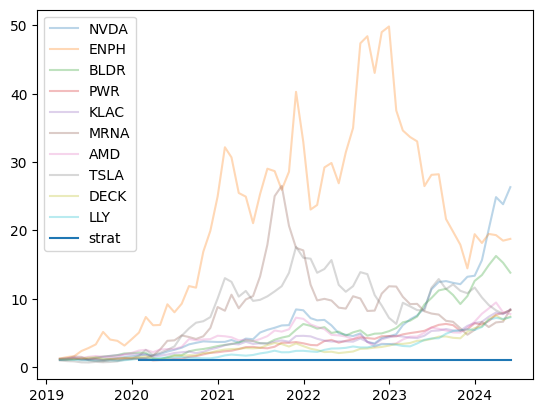

In [28]:
# plotting greatest 10 stocks(w/o outlier 8227.TWO) vs. strategy
top = 10
close_t = close.T
close_t["total_return"] = (close_t.iloc[:, -1] - close_t.iloc[:, 0])/close_t.iloc[:, 0]
close_order_by_total_return = close_t.sort_values(by='total_return', ascending=False).iloc[1:top+1, :-1].T # 8227: outlier
close_order_by_total_return.index = pd.to_datetime(close_order_by_total_return.index)
top10_resample_m = close_order_by_total_return.resample("M").mean()
close_order_by_total_return_cumprod = (1+top10_resample_m.pct_change()).cumprod()
plt.plot(close_order_by_total_return_cumprod, label=close_order_by_total_return_cumprod.columns, alpha=0.3)
plt.plot(returns_series, label='strat')
plt.legend()


In [188]:
for index, row in normalized_long_weights.iterrows():
    holdings = row[row > 0].index
    if "8227.TWO" in holdings:
        print(row.name)

2020-03-31 00:00:00
2020-04-30 00:00:00
2020-05-31 00:00:00
2020-06-30 00:00:00
2020-07-31 00:00:00
2020-10-31 00:00:00
2021-07-31 00:00:00
2021-08-31 00:00:00
2021-09-30 00:00:00
2021-10-31 00:00:00
2021-11-30 00:00:00
2021-12-31 00:00:00
2022-01-31 00:00:00
2022-02-28 00:00:00
2022-03-31 00:00:00
2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-10-31 00:00:00
2022-12-31 00:00:00
2023-01-31 00:00:00
2023-03-31 00:00:00
2023-04-30 00:00:00
2023-05-31 00:00:00
2023-06-30 00:00:00
2023-07-31 00:00:00
2023-08-31 00:00:00
2023-09-30 00:00:00
2023-10-31 00:00:00
2023-11-30 00:00:00
2023-12-31 00:00:00
